In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
import pickle
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, concatenate, Lambda, BatchNormalization
from keras import metrics
from preprocessing import PreProcessing
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
data_path = r"/content/drive/My Drive/Colab Notebooks/data"

preprocess_data = PreProcessing(data_path, verbose=True)

In [0]:
batch_size = 4
anchor_image, positive_image, negative_image = preprocess_data.get_triplet_batch(batch_size,train_data=False)


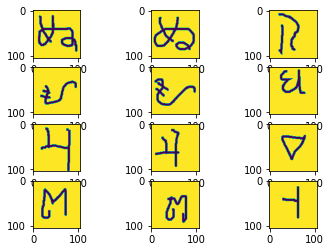

In [6]:
fig, ax = plt.subplots(nrows=batch_size, ncols=3)
for i in range(batch_size):
    ax[i, 0].imshow(np.reshape(anchor_image[i], (105, 105)))
    ax[i, 1].imshow(np.reshape(positive_image[i], (105, 105)))
    ax[i, 2].imshow(np.reshape(negative_image[i], (105, 105)))
plt.show()

In [7]:
anchor_image.shape

(4, 105, 105, 1)

Cell before defines for the structure of the CNN that extract the embedding from the Image

In [0]:
# emb_size = 128
emb_size = 2048
embedding_model = Sequential()
embedding_model.add(Conv2D(64, (10,10), activation='relu', input_shape=(105,105,1)))
embedding_model.add(BatchNormalization())
embedding_model.add(MaxPooling2D())
embedding_model.add(Dropout(0.5))
embedding_model.add(Conv2D(128, (7,7), activation='relu'))
embedding_model.add(BatchNormalization())
embedding_model.add(MaxPooling2D())
embedding_model.add(Dropout(0.5))
embedding_model.add(Conv2D(128, (4,4), activation='relu'))
embedding_model.add(BatchNormalization())
embedding_model.add(MaxPooling2D())
embedding_model.add(Dropout(0.5))
embedding_model.add(Conv2D(256, (4,4), activation='relu'))
embedding_model.add(BatchNormalization())
embedding_model.add(Flatten())
embedding_model.add(Dense(emb_size, activation='sigmoid'))
embedding_model.add(Lambda(lambda x:tf.keras.backend.l2_normalize(x, axis=1)))
# embedding_model.summary()

In [9]:
test_embedding_output1 = embedding_model.predict(np.expand_dims(anchor_image[3], axis=0))
test_embedding_output2 = embedding_model.predict(np.expand_dims(positive_image[3], axis=0))
test_embedding_output3 = embedding_model.predict(np.expand_dims(negative_image[3], axis=0))
print(test_embedding_output1.shape)
distance1 = tf.sqrt(tf.reduce_sum(tf.pow(test_embedding_output1 - test_embedding_output2, 2), 1, keepdims=True))
distance2 = tf.sqrt(tf.reduce_sum(tf.pow(test_embedding_output1 - test_embedding_output3, 2), 1, keepdims=True))
loss = tf.reduce_mean(tf.maximum(distance1 - distance2 + 0.2, 0.))
distance1, distance2, loss


(1, 2048)


(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00766199]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0071888]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.2004732>)

In [0]:
in_anc = Input(shape=(105,105,1))
in_pos = Input(shape=(105,105,1))
in_neg = Input(shape=(105,105,1))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = concatenate([em_anc, em_pos, em_neg], axis=1)

siamese_net = Model(
    [in_anc, in_pos, in_neg],
    out
)

# siamese_net.summary()

Triplet Loss function for L2 Distance 

In [0]:
# L2 Distance
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.sqrt(tf.reduce_sum(tf.pow(anc - pos, 2), 1, keepdims=True))
        distance2 = tf.sqrt(tf.reduce_sum(tf.pow(anc - neg, 2), 1, keepdims=True))
        return tf.reduce_mean(tf.maximum(distance1 - distance2 + alpha, 0.))
    return loss

Triplet loss function for Cosine Distance

In [0]:
# Cosine Similarity
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.keras.losses.cosine_similarity(anc, pos)
        distance2 = tf.keras.losses.cosine_similarity(anc, neg)
        return tf.keras.backend.clip(distance1 - distance2 + alpha, 0., None)
    return loss

In [ ]:
def data_generator(batch_size, emb_size):
    while True:
        x = preprocess_data.get_triplet_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x,y

In [0]:
batch_size = 128
epochs = 50
opt = tf.keras.optimizers.Adam(lr = 0.001)
steps_per_epoch = 100
siamese_net.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_size), optimizer=opt)
# siamese_net.summary()


In [14]:
save_path = os.path.join(data_path, "model_weights_triplet_loss_2048.h5")


history = siamese_net.fit(
    data_generator(batch_size, emb_size),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=True
)


Epoch 1/50
100/100 [==============================] - 37s 371ms/step - loss: 0.0529
Epoch 2/50
100/100 [==============================] - 34s 343ms/step - loss: 0.0376
Epoch 3/50
100/100 [==============================] - 34s 343ms/step - loss: 0.0282
Epoch 4/50
100/100 [==============================] - 34s 342ms/step - loss: 0.0218
Epoch 5/50
100/100 [==============================] - 34s 342ms/step - loss: 0.0181
Epoch 6/50
100/100 [==============================] - 34s 342ms/step - loss: 0.0169
Epoch 7/50
100/100 [==============================] - 34s 342ms/step - loss: 0.0145
Epoch 8/50
100/100 [==============================] - 34s 342ms/step - loss: 0.0130
Epoch 9/50
100/100 [==============================] - 34s 342ms/step - loss: 0.0122
Epoch 10/50
100/100 [==============================] - 34s 341ms/step - loss: 0.0120
Epoch 11/50
100/100 [==============================] - 34s 341ms/step - loss: 0.0105
Epoch 12/50
100/100 [==============================] - 34s 341ms/step - lo

In [0]:
siamese_net.load_weights(save_path)

In [0]:
siamese_net.save_weights(save_path)

In [16]:
print(history.history['loss'])

[0.05286350743845105, 0.03755243882536888, 0.028226286098361017, 0.02178509496152401, 0.018149997843429445, 0.01690572826191783, 0.014511484568938613, 0.013049100106582046, 0.012229221742600202, 0.01204013437498361, 0.010457476540468634, 0.009847868289798499, 0.009387117130681872, 0.009888037266209721, 0.009103208314627409, 0.008159786482574418, 0.00841076581273228, 0.00782000765670091, 0.007550552679458633, 0.006903479637112468, 0.006760420756181702, 0.006156597326043994, 0.0058259945653844625, 0.005892282574204728, 0.0063951707084197555, 0.006313020214438438, 0.006103568221442401, 0.005671543204225599, 0.005769486258504913, 0.00542102255858481, 0.004934863779926673, 0.005083892116090283, 0.004498201833339408, 0.004754123879829422, 0.004920696301851422, 0.004557946708519012, 0.004633598095970228, 0.004327973298495635, 0.004111444635782391, 0.0041760730766691265, 0.00413331470801495, 0.004233859536470846, 0.0037837474583648145, 0.004170246322173625, 0.0037335957866162063, 0.00412656722

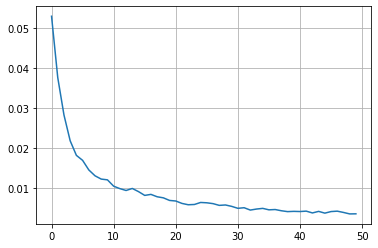

In [17]:
plt.plot(history.history['loss'], label='Loss')
plt.grid(True)
plt.show()

In [18]:
test_sample = 1000
nway_min = 5
nway_max = 25
test_acc = []
nway_list = []
for nway in range(nway_min, nway_max+1,5):
  print("Checking %d way accuracy...." % nway)
  correct_count = 0
  for _ in range(test_sample):
    # Retrieving nway number of triplets and calculating embedding vector
    nway_anchor, nway_positive, _ = preprocess_data.get_triplet_batch(nway, train_data=False)
    nway_anchor_embedding = embedding_model.predict(nway_anchor)
    sample_index = random.randint(0,nway-1)
    sample_embedding = embedding_model.predict(np.expand_dims(nway_positive[sample_index], axis=0))
    # print(sample_index, nway_anchor_embedding.shape, sample_embedding.shape)
    distance = tf.sqrt(tf.reduce_sum(tf.pow(nway_anchor_embedding - sample_embedding, 2), 1, keepdims=True)).numpy()
    if np.argmin(distance) == sample_index:
      correct_count+=1
  nway_list.append(nway)
  acc = (correct_count/test_sample)*100.
  test_acc.append(acc)
  print("Accuracy %.2f" % acc)

Checking 5 way accuracy....
Accuracy 98.90
Checking 10 way accuracy....
Accuracy 96.30
Checking 15 way accuracy....
Accuracy 94.70
Checking 20 way accuracy....
Accuracy 93.70
Checking 25 way accuracy....
Accuracy 92.70


In [19]:
test_sample = 1000
nway_min = 5
nway_max = 25
train_acc = []
nway_list = []
for nway in range(nway_min, nway_max+1,5):
  print("Checking %d way accuracy...." % nway)
  correct_count = 0
  for _ in range(test_sample):
    # Retrieving nway number of triplets and calculating embedding vector
    nway_anchor, nway_positive, _ = preprocess_data.get_triplet_batch(nway, train_data=True)
    nway_anchor_embedding = embedding_model.predict(nway_anchor)
    sample_index = random.randint(0,nway-1)
    sample_embedding = embedding_model.predict(np.expand_dims(nway_positive[sample_index], axis=0))
    # print(sample_index, nway_anchor_embedding.shape, sample_embedding.shape)
    distance = tf.sqrt(tf.reduce_sum(tf.pow(nway_anchor_embedding - sample_embedding, 2), 1, keepdims=True)).numpy()
    if np.argmin(distance) == sample_index:
      correct_count+=1
  nway_list.append(nway)
  acc = (correct_count/test_sample)*100.
  train_acc.append(acc)
  print("Accuracy %.2f" % acc)

Checking 5 way accuracy....
Accuracy 98.70
Checking 10 way accuracy....
Accuracy 97.00
Checking 15 way accuracy....
Accuracy 94.90
Checking 20 way accuracy....
Accuracy 94.10
Checking 25 way accuracy....
Accuracy 92.70


<function matplotlib.pyplot.show>

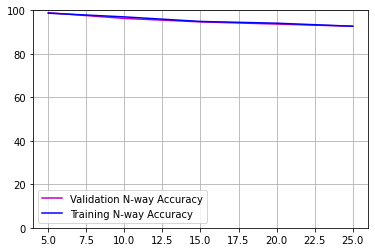

In [20]:
# Test & Train set accuracy Graph
plt.plot(nway_list, test_acc, 'm', label='Validation N-way Accuracy')
plt.plot(nway_list, train_acc, 'b', label='Training N-way Accuracy')
plt.axis([None, None, 0, 100])
plt.grid(True)
plt.legend(loc='lower left')
plt.show